# Practical tips for class imbalance in binary classification
---
###  _Zichen Wang_
### _Ma'ayan lab meeting_
### _Feb. 26, 2016_
---

## 0. Introduction and motivation

+ ### Binary classification
    + Supervised machine learning
    + Learn a function _f_ that map _x_ (vector of features for an instance) to binary outcome (0 or 1)
    + _y = f(X)_,
    + where X is a matrix with shape of (instances * features), and y is the binary vector corresponding to the class of instances on the rows of X
    

+ ### Class imbalance

    + > The reviewer is curious how unbalanced class sizes were being handled. In particular, some ADRs might have a lot of 0's versus 1's as the response vector.  Did the unbalanced class sizes create any issues for your feature selection and classification methods?

    + Class imbalance: the classes are not represented equally in a classification problem
    + Class imbalance is common:
        + Fraud detection
        + Rare adverse drug reactions
        + Predict gene families (e.g. Kinase, GPCR)


In [1]:
% matplotlib inline
from collections import OrderedDict
from utils import *

In [2]:
# Load some data
# Go to prepare_data.ipynb to show how these data were prepared.
# X, y = load_titanic()
X, y = load_proteomics()
# X, y = load_wpbc()

print X.shape, y.shape
print 'positive class ratio', y.sum()/float(y.shape[0])

(1863, 53) (1863,)
positive class ratio 0.0182501341922


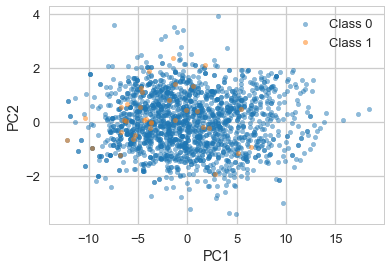

In [3]:
# PCA
fig = pca_plot(X, y)

## 1. Straitification matters!

Straitification: allocate the samples evenly based on sample classes so that training set and test set have similiar ratio of classes.

In [4]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
cv = KFold(n_splits=3)
scv = StratifiedKFold(n_splits=3)
# Examine the positive label in train and test folds
print 'KFold not Stratified'
for train_idx, test_idx in cv.split(y):
    print y[train_idx].sum(), y[test_idx].sum()

print 'StratifiedKFold'
for train_idx, test_idx in scv.split(X, y):
    print y[train_idx].sum(), y[test_idx].sum()


KFold not Stratified
18 16
22 12
28 6
StratifiedKFold
22 12
23 11
23 11


In [5]:
X.shape, y.shape

((1863, 53), (1863,))

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import linear_model
clf = GaussianNB()
# clf = linear_model.LogisticRegression()
# clf = RandomForestClassifier(n_estimators=5, random_state=RNG)
# clf = DecisionTreeClassifier(random_state=RNG)
# clf = SVC(probability=True, random_state=RNG)
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random', 'Stratified'])
for metric in metric_names:
    score1 = cross_val_score(clf, X, y, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X, y, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

scores_df

,Random,Stratified
f1,0.0634488,0.0664559
roc_auc,0.697767,0.668807
average_precision,0.037918,0.0400504
accuracy,0.641439,0.644766
precision,0.0332692,0.0350948
recall,0.729167,0.646465


## 2. Performance metrics for binary classification

+ ### Accuracy is misleading
![Accuracy](https://upload.wikimedia.org/math/8/c/3/8c3f5b1cef3a52644de5056fd2fafee6.png)
+ ### Confusion matrix helps break down the predictive performance to different classes
![Confusion matrix](http://www.dataschool.io/content/images/2015/01/confusion_matrix2.png)
+ ### Bipartition based metrics (Precision, Recall, F1-score) differs depending on the positive class
Precision or positive predictive value (PPV) 
![Precision](https://upload.wikimedia.org/math/6/b/5/6b55614c9bcfa7596145265be222c4c9.png)
Recall or true positive rate (TPR) or sensitivity 
![Recall](https://upload.wikimedia.org/math/8/b/f/8bf211db6603570bbb1926f911097b18.png)
F1-score (harmonic mean of Precision and Recall) 
![F1-score](https://upload.wikimedia.org/math/9/9/1/991d55cc29b4867c88c6c22d438265f9.png)

+ ### ROC curve is useful for selecting threshold for model
+ ### [Precision-Recall curve is recommended over ROC for imbalanced data](http://www.nature.com/nmeth/journal/v13/n8/fig_tab/nmeth.3945_F4.html)

In [7]:
from sklearn import metrics
train_idx, test_idx = scv.split(X, y).next()
clf = RandomForestClassifier(n_estimators=10, random_state=RNG)

clf.fit(X[train_idx], y[train_idx])
print X[train_idx].shape, X[test_idx].shape
y_probas = clf.predict_proba(X[test_idx])[:,1]
y_preds = clf.predict(X[test_idx])

## confusion matrix
print '--confusion matrix--'
cm = metrics.confusion_matrix(y[test_idx], y_preds, labels=[0,1])
print cm
print '--classification report --'
print metrics.classification_report(y[test_idx], y_preds, labels=[0,1])

(1241, 53) (622, 53)
--confusion matrix--
[[607   3]
 [ 11   1]]
--classification report --
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       610
          1       0.25      0.08      0.12        12

avg / total       0.97      0.98      0.97       622



In [8]:
# Metrics of the rare class
print metrics.recall_score(y[test_idx], y_preds, pos_label=0)
print metrics.recall_score(y[test_idx], y_preds, pos_label=1)

0.995081967213
0.0833333333333


AUROC = 0.549932
Accuracy = 0.977492


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


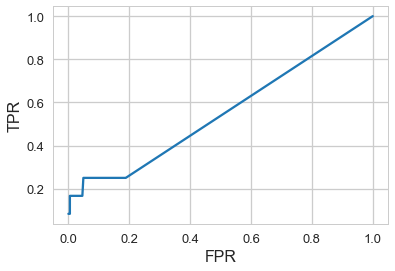

In [9]:
# plot scores across thresholds
fig, ax = plt.subplots()

fpr, tpr, thresholds = metrics.roc_curve(y[test_idx], y_probas)
ax.plot(fpr, tpr, color=COLORS10[0])

ax.legend(loc='best')
ax.set_xlabel('FPR', fontsize=16)
ax.set_ylabel('TPR', fontsize=16)
print 'AUROC = %.6f' % metrics.auc(fpr, tpr)
print 'Accuracy = %.6f' % metrics.accuracy_score(y[test_idx], y_preds)

AUPRC = 0.138712
Accuracy = 0.977492


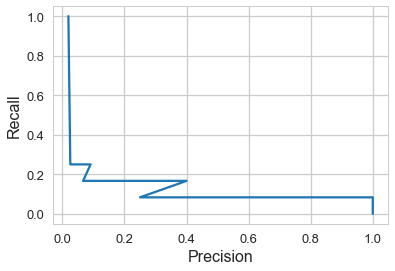

In [10]:
# plot scores across thresholds
fig, ax = plt.subplots()

pr, rc, thresholds = metrics.precision_recall_curve(y[test_idx], y_probas)
ax.plot(pr, rc, color=COLORS10[0])

ax.legend(loc='best')
ax.set_xlabel('Precision', fontsize=16)
ax.set_ylabel('Recall', fontsize=16)
print 'AUPRC = %.6f' % metrics.average_precision_score(y[test_idx], y_probas)
print 'Accuracy = %.6f' % metrics.accuracy_score(y[test_idx], y_preds)

## 3. Resampling to get more balanced data
+ Down-sampling (Under sampling)
+ Up-sampling (Over sampling)
+ Many more sampling techniques implemented in [UnbalancedDataset](https://github.com/fmfn/UnbalancedDataset)

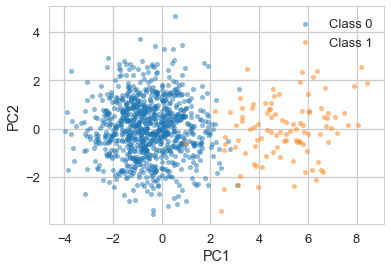

In [11]:
# Demo of the effect of resampling
# Load synthetic data
X, y = load_synthetic_data()
# Original
fig = pca_plot(X, y)

(200, 50) (1000, 50)


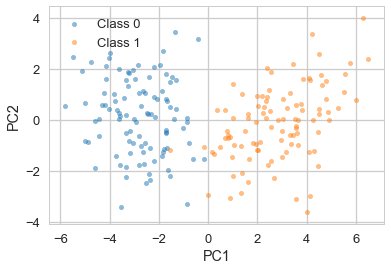

In [12]:
from imblearn.under_sampling import RandomUnderSampler as UnderSampler
from imblearn.over_sampling import RandomOverSampler as OverSampler
# Down-sampling
us = UnderSampler()
X_dn, y_dn = us.fit_sample(X, y)
fig = pca_plot(X_dn, y_dn)
print X_dn.shape, X.shape

(1800, 50) (1000, 50)


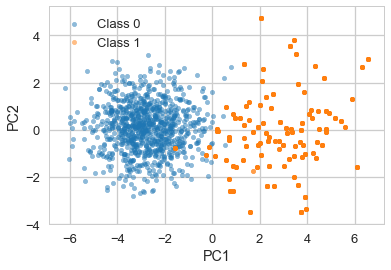

In [13]:
# Up-sampling
us = OverSampler()
X_up, y_up = us.fit_sample(X, y)
fig = pca_plot(X_up, y_up)
print X_up.shape, X.shape

In [14]:
# up, down RandomForest
from sklearn.base import clone
from resample_forest import ResampleForestClassifier
tree = DecisionTreeClassifier()
rf = ResampleForestClassifier(tree, n_estimators=10, sampling=None, random_state=RNG, verbose=False)
rf_up = ResampleForestClassifier(tree, n_estimators=10, sampling='up', random_state=RNG, verbose=False)
rf_dn = ResampleForestClassifier(tree, n_estimators=10, sampling='down', random_state=RNG, verbose=False)

/usr/local/lib/python2.7/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


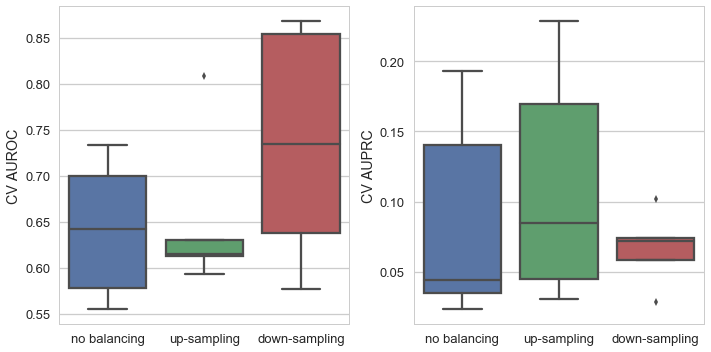

In [15]:
X, y = load_proteomics()
cv = StratifiedKFold(n_splits=5)
labels = ['no balancing', 'up-sampling', 'down-sampling']
clfs = [rf, rf_up, rf_dn]

aurocs = OrderedDict()
auprcs = OrderedDict()
for i in range(3):
    clf = clfs[i]
    aurocs[labels[i]] = cross_val_score(clf, X, y, scoring='roc_auc', cv=cv)
    auprcs[labels[i]] = cross_val_score(clf, X, y, scoring='average_precision', cv=cv)

aurocs = pd.DataFrame(aurocs)
auprcs = pd.DataFrame(auprcs)
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=aurocs, ax=axes[0])
axes[0].set_ylabel('CV AUROC')

sns.boxplot(data=auprcs, ax=axes[1])
axes[1].set_ylabel('CV AUPRC')
fig.tight_layout()
plt.show()

In [16]:
# up-sampling may overfit?
# Plot train score vs. test score
train_scores = np.zeros((3, cv.n_splits))
test_scores = np.zeros((3, cv.n_splits))

from sklearn.base import clone
for i, clf in enumerate([rf, rf_up, rf_dn]):
    j = 0
    for train_idx, test_idx in cv.split(X, y):
        clf = clone(clf) # to make sure no data is attached to clf
        clf.fit(X[train_idx], y[train_idx])
        y_probas = clf.predict_proba(X)[:, 1]
        
        train_auc = metrics.roc_auc_score(y[train_idx], y_probas[train_idx])
        test_auc = metrics.roc_auc_score(y[test_idx], y_probas[test_idx])
        
        train_scores[i, j] = train_auc
        test_scores[i, j] = test_auc
        j += 1
        
x = range(3)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

train AUROCs: [ 0.99933406  0.99966399  0.99549394]
test AUROCs: [ 0.64154802  0.65170393  0.73411355]


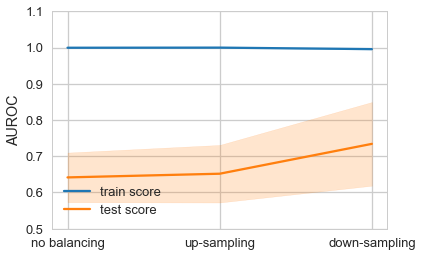

In [17]:
print 'train AUROCs:', train_mean
print 'test AUROCs:', test_mean
fig, ax = plt.subplots()
ax.plot(x, train_mean, label='train score', color=COLORS10[0])
ax.fill_between(x,  train_mean-train_std, train_mean+train_std, color=COLORS10[0], alpha=0.2)
ax.plot(x, test_mean, label='test score', color=COLORS10[1])
ax.fill_between(x,  test_mean-test_std, test_mean+test_std, color=COLORS10[1], alpha=0.2)
ax.legend(loc='best')
ax.set_ylabel('AUROC')
ax.set_ylim([0.5,1.1])
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

### Validation curve
+ Training scores: how well the classifier fit the training data.
+ Test scores: how well the classifier fit the hold-out test data.
+ Determine training and test scores for varying parameter values.


In [18]:
# Plot validataion curve
from sklearn.model_selection import validation_curve
def plot_valitation_curve(clf, X, y, ax, **kwargs):
    '''To plot validation curve over a range of parameter'''
    train_scores, test_scores = validation_curve(
        clf, X, y, **kwargs)
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    x = kwargs['param_range']
    ax.plot(x, train_mean, label='train score', color=COLORS10[0])
    ax.fill_between(x,  train_mean-train_std, train_mean+train_std, color=COLORS10[0], alpha=0.2)
    ax.plot(x, test_mean, label='test score', color=COLORS10[1])
    ax.fill_between(x,  test_mean-test_std, test_mean+test_std, color=COLORS10[1], alpha=0.2)
    ax.legend(loc='best')
    if kwargs['scoring'] == 'roc_auc':
        ax.set_ylim([0.5,1.1])
    return ax

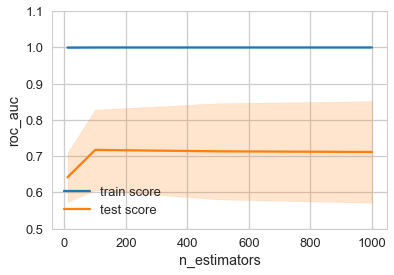

In [19]:
fig, ax = plt.subplots()
ax = plot_valitation_curve(ResampleForestClassifier(tree, sampling=None, random_state=RNG), 
                      X, y, ax,
                      cv=cv,
                      param_name='n_estimators',
                      scoring='roc_auc',
                      n_jobs=6,
                      param_range=[10,100, 500, 1000])
ax.set_xlabel('n_estimators')
ax.set_ylabel('roc_auc');

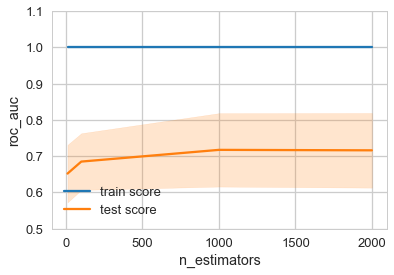

In [20]:
fig, ax = plt.subplots()
ax = plot_valitation_curve(ResampleForestClassifier(tree, sampling='up', random_state=RNG), 
                      X, y, ax,
                      cv=cv,
                      param_name='n_estimators',
                      scoring='roc_auc',
                      n_jobs=6,
                      param_range=[10,100, 1000, 2000])
ax.set_xlabel('n_estimators')
ax.set_ylabel('roc_auc');

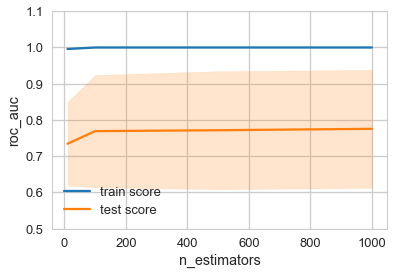

In [21]:
fig, ax = plt.subplots()
ax = plot_valitation_curve(ResampleForestClassifier(tree, sampling='down', random_state=RNG), 
                      X, y, ax,
                      cv=cv,
                      param_name='n_estimators',
                      scoring='roc_auc',
                      n_jobs=6,
                      param_range=[10,100, 500, 1000])
ax.set_xlabel('n_estimators')
ax.set_ylabel('roc_auc');

## 4. Class weighted / cost sensitive learning
+ To incorperate the weights of two classes (0 and 1) into the cost function of classifier.
+ Can be achieved by setting the `class_weight` parameter in scikit-learn
    + `class_weight='balanced'`: uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
    + `class_weight='balanced_subsample'`: is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

In [22]:
# RF
rf = RandomForestClassifier(n_estimators=10, random_state=RNG)
rf_balanced = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=RNG)
rf_balanced2 = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', random_state=RNG)

X, y = load_proteomics()
# X, y = load_titanic()
# X, y = load_wpbc()
cv = StratifiedKFold(n_splits=5)
for clf in [rf, rf_balanced, rf_balanced2]:
    print cross_val_score(clf, X, y, scoring='roc_auc', cv=cv).mean()


0.631311689284
0.649465635794
0.672705826997


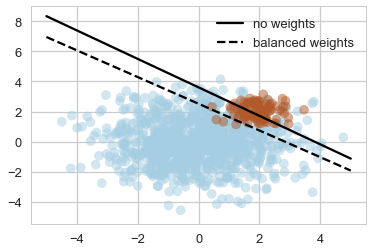

In [23]:
# SVM decision boundary
# modified from http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

# we create 40 separable points
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X = np.r_[1.5 * rng.randn(n_samples_1, 2),
          0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y = [0] * (n_samples_1) + [1] * (n_samples_2)

# fit the model and get the separating hyperplane
clf = SVC(kernel='linear', C=1.0)
clf.fit(X, y)

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - clf.intercept_[0] / w[1]


# get the separating hyperplane using weighted classes
wclf = SVC(kernel='linear', class_weight='balanced')
wclf.fit(X, y)

ww = wclf.coef_[0]
wa = -ww[0] / ww[1]
wyy = wa * xx - wclf.intercept_[0] / ww[1]

# plot separating hyperplanes and samples
h0 = plt.plot(xx, yy, 'k-', label='no weights')
h1 = plt.plot(xx, wyy, 'k--', label='balanced weights')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, alpha=0.5)
plt.legend()

plt.axis('tight');

## 5. Gradient Boosting
"Gradient boosting is a principled method of dealing with class imbalance by constructing successive training sets based on incorrectly classified examples."

In [24]:
import xgboost as xgb

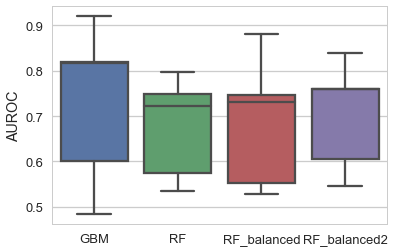

In [25]:
# Compare preformance of classifiers
n_estimators = 20
gbm = xgb.XGBClassifier(n_estimators=n_estimators, subsample=.8, seed=RNG)
rf = RandomForestClassifier(n_estimators=n_estimators, random_state=RNG)
rf_balanced = RandomForestClassifier(n_estimators=n_estimators, random_state=RNG, class_weight='balanced')
rf_balanced2 = RandomForestClassifier(n_estimators=n_estimators, random_state=RNG, class_weight='balanced_subsample')

X, y = load_proteomics()
cv = StratifiedKFold(n_splits=5)
clf_names = ['GBM', 'RF', 'RF_balanced', 'RF_balanced2']
clfs = [gbm, rf, rf_balanced, rf_balanced2]
all_scores = np.zeros((len(clf_names), cv.n_splits))
for i in range(len(clfs)):
    clf = clone(clfs[i])
    scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    all_scores[i] = scores

fig, ax = plt.subplots()
sns.boxplot(data=pd.DataFrame(all_scores.T, columns=clf_names), ax=ax)
ax.set_ylabel('AUROC')